#### Excersise 6:
Consider a finger print Photo and find it's ridge's orientation following the procedure below :

##### A)Find each pixel's orientaion (an integer number between 0~180)

##### B)Map each number found in the previous step to an integer number between 1 and 8

##### C)Divide the photo in to 16x16 blocks and find the dominant ridge orientation for each block

##### D)Draw the dominant ridge orientation on the finger print photo

In [1]:
# importing used libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
import math


## Part A
#### The following function calculates each pixel's orientaion in the photo based on BlockSize and QuantizationFactor
#### BlockSize sets the neighbourhood window size used to calculate the orientation for each pixel
#### QuantizationFactor sets the number of regions between 0 and 180 used for quantization of angles

In [2]:
def calculateRidgeDirection(img, windowSize, quantizationFactor=8):
    
    # converting photo to gray scale image for performance in Gradian calculation
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    imgHeight, imgWidth = img.shape

    # WindowSize should alwayse be an on number ensuring that the pixel itself as at the center of window
    if windowSize % 2 != 1:
        raise Exception("invalid Window Size")

    # border size used for padding the original image
    m = int((windowSize - 1) / 2)
    
    # padding the original photi
    paddedImage = np.zeros((imgHeight + 2 * m, imgWidth + 2 * m))
    paddedImage[m:-m, m:-m] = img
    
    # Calculate the Sobel Gradient on both X and Y direction
    Gx = cv2.Sobel(paddedImage, -1, 1, 0)
    Gy = cv2.Sobel(paddedImage, -1, 0, 1)
    
    # Required terms for the formula used to calculate Ridge's orientation
    
    # theta=pi/2+1/2*arctan(2*GxGy/(G2x-G2Y))
    
    G2x = Gx * Gx
    G2y = Gy * Gy
    
    
    # PreAllocation Results 
    result = np.zeros((imgHeight + 2 * m, imgWidth + 2 * m))
    
    # Numerator and Denumerator Terms in the formula
    A = G2x - G2y
    B = 2 * Gx * Gy
    
    # The calculation loop
    
    for x in range(m, result.shape[0] - m):
        for y in range(m, result.shape[1] - m):
            Numerator = np.sum(A[x - m:x + m + 1, y - m:y + m + 1])
            Denuminator = np.sum(B[x - m:x + m + 1, y - m:y + m + 1])
            
            # making sure ambiguous 0/0 doesn't happen
            if Denuminator != 0 and Numerator != 0:
                
                # due to drawing proccess used we slightly change the formula in to pi/4 +.5*arctan((G2x-G2y)/(2GxGy))
                result[x, y] = math.pi/4+.5*math.atan2(Numerator, Denuminator)
                
    # Converting radian to Gradian
    retVal = np.rad2deg(result)
    retVal = mapAngle2Num(retVal[m:-m, m:-m], levels=quantizationFactor)
    return retVal


## Part B
#### functions to do the conversion required

In [3]:


def mapAngle2Num(matrix, Range=(0, 180), levels=8):
    rMin, rMax = Range
    m = (rMax - rMin) / levels / 2
    matrix = np.mod(matrix + rMax, rMax)
    ones = np.logical_or(matrix < m, matrix > (rMax - m))
    retVal = np.floor((matrix - m) / (2 * m)) + 2
    retVal[ones] = 1
    return retVal.astype(np.int)


def mapNum2Angle(matrix, Range=(0, 180), levels=8):
    rMin, rMax = Range
    m = (rMax - rMin) / levels / 2
    ones = matrix == 1
    retVal = (matrix - 2) * 2 * m + m
    if type(matrix) is np.ndarray:
        retVal[ones] = 0

    return retVal


## Part C
#### Function used to find Dominant orientation

#


In [4]:
def findMostRepated(matrix):
    histogram = []
    elementsInMatrix = set(matrix.flatten())
    for element in elementsInMatrix:
        histogram.append((element, np.sum(matrix == element)))

    maxRepeated = histogram[0]
    for element, elementCount in histogram:
        if elementCount > maxRepeated[1]:
            maxRepeated = (element, elementCount)

    return maxRepeated[0]



## Part D
#### Drawing Functions




###  Draw a line in to a block of size winSize and angle angleDegree
#### x and y are respectively rows and column of a matrix
#### We consider the matrix as the first octant of a 2 dimentional plane
#### then we move the origin to the center of the matrix
#### we draw the line based on equation y=mx which m=tan(angleDegree)
#### finally we rotate the matrix counter clock wise 

In [5]:
def drawAngle(angleDegree, winSize=(16, 16)):
    imgHeight, imgWidth = winSize
    m = int(np.floor(imgHeight / 2))
    n = int(np.floor(imgWidth / 2))

    a = np.tan(np.deg2rad(angleDegree))

    drawPlane = np.zeros(winSize)
    pointList = []

    for x in range(-n, n + 1):
        if -n <= math.floor(a * x) <= n:
            pointList.append((x, math.floor(a * x)))

    for pt in pointList:
        x, y = pt
        # fix thissss
        if x < imgHeight and y < imgWidth:
            drawPlane[x + m - 1:x + m + 1, y + n - 1:y + n + + 1] = 255

    return np.rot90(drawPlane,k=1)


## Finally we put together all of the funcions above in to one General function
## and follow the precedure mentioned to draw Ridges

In [6]:
def drawRidges(img, windowSize=(16, 16), quantizationFactor=8):
    imgHeight, imgWidth = img.shape[:2]
    winHeight, winWidth = windowSize

    edgeDirections = calculateRidgeDirection(img, 17, quantizationFactor=quantizationFactor)

    if imgHeight % winHeight != 0 or imgWidth % winWidth != 0:
        print("window and image size doesn't match")
        paddedImage = np.zeros(((imgHeight // winHeight + 1) * winHeight, (imgWidth // winWidth + 1) * winWidth))
        paddedImage[:imgHeight, :imgWidth] = edgeDirections
    result = np.zeros_like(paddedImage)

    for i in range(0, paddedImage.shape[0], winWidth):
        for j in range(0, paddedImage.shape[1], winWidth):
            maxRepeatedAng = findMostRepated(paddedImage[i:i + winHeight, j:j + winWidth])

            result[i:i + winHeight, j:j + winWidth] = drawAngle(
                mapNum2Angle(maxRepeatedAng, levels=quantizationFactor),
                windowSize)

    return result[:imgHeight, :imgWidth]



### Simple Functiond To Draw Images More Clearly

In [7]:

def drawConfig(image,winSize=(16,16),quantizationFactor=8,color=[0,255,255]):
    
    figure=plt.figure(figsize=(24,20))
    ridges=drawRidges(image,windowSize=winSize,quantizationFactor=quantization)
    ridgesAndImage=image.copy()
    ridgesAndImage[ridges==255]=np.array(color)
    figure.add_subplot(131).imshow(image)
    figure.add_subplot(132).imshow(ridges,cmap='gray')
    figure.add_subplot(133).imshow(ridgesAndImage)

# Example

In [8]:
# opening the image
image=cv2.imread("6.tif")

## Quantization Effect

window and image size doesn't match


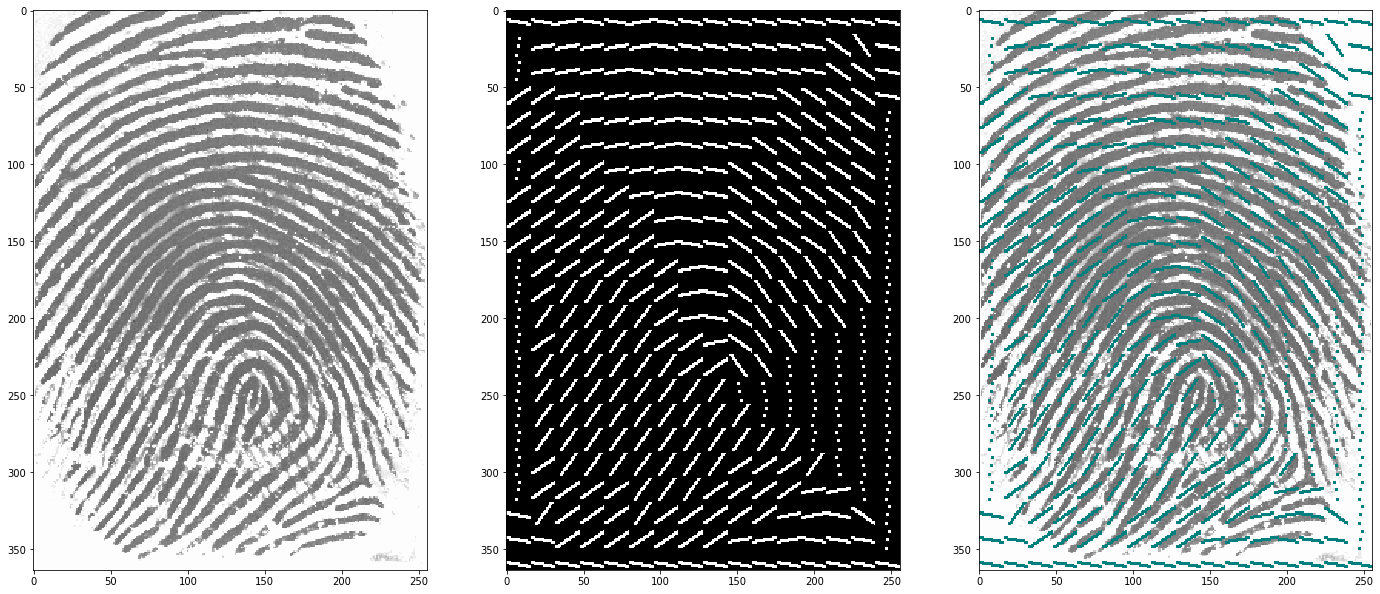

In [9]:
blockSize=(16,16)
quantization=8
color=[0,127,127]
drawConfig(image,winSize=blockSize,quantizationFactor=quantization,color=color)

window and image size doesn't match


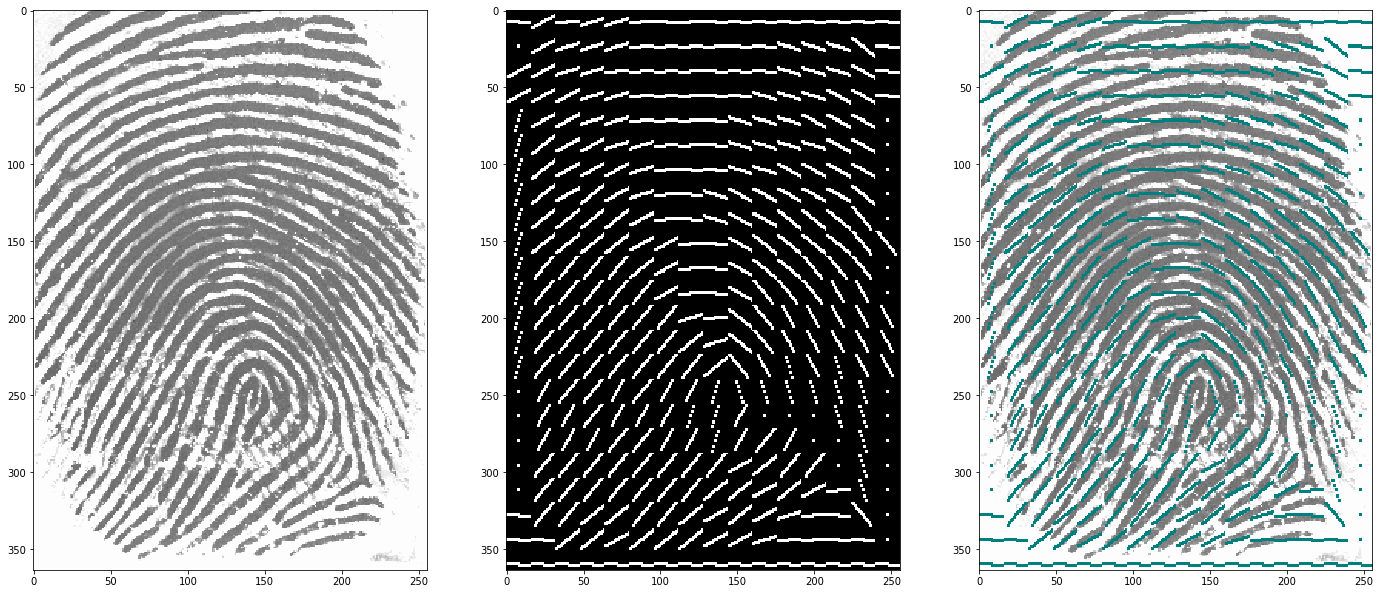

In [10]:
blockSize=(16,16)
quantization=16
color=[0,127,127]
drawConfig(image,winSize=blockSize,quantizationFactor=quantization,color=color)

window and image size doesn't match


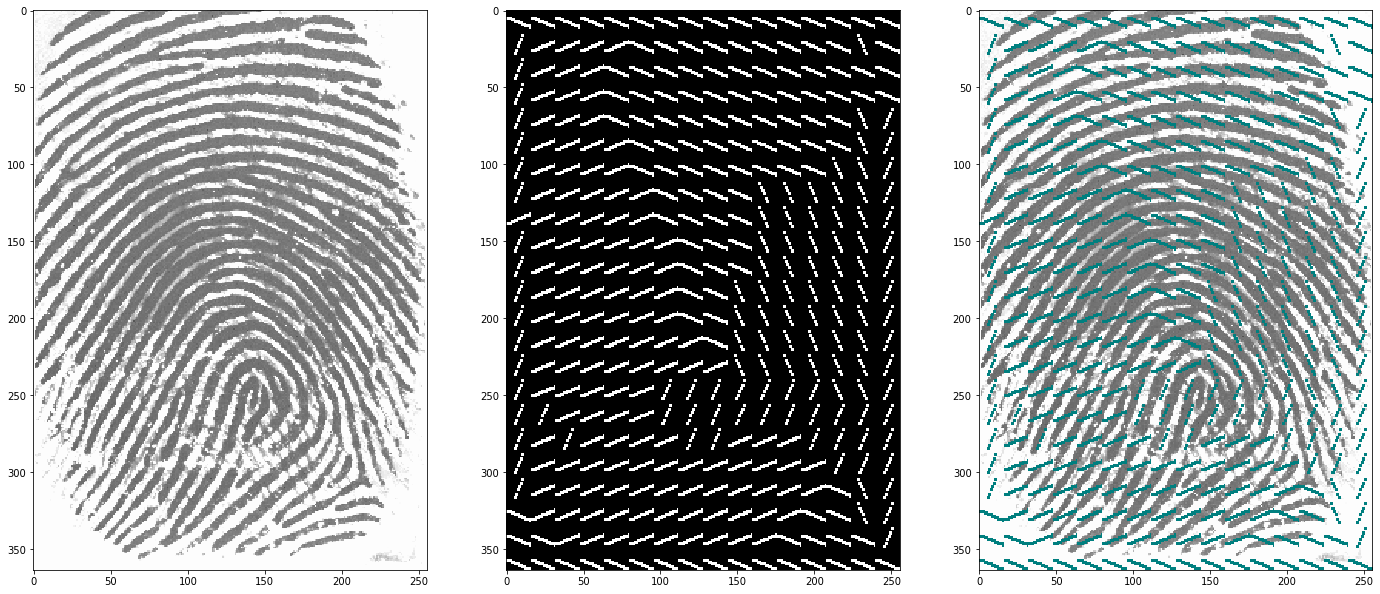

In [11]:
blockSize=(16,16)
quantization=4
color=[0,127,127]
drawConfig(image,winSize=blockSize,quantizationFactor=quantization,color=color)

## Block Size Effect

window and image size doesn't match


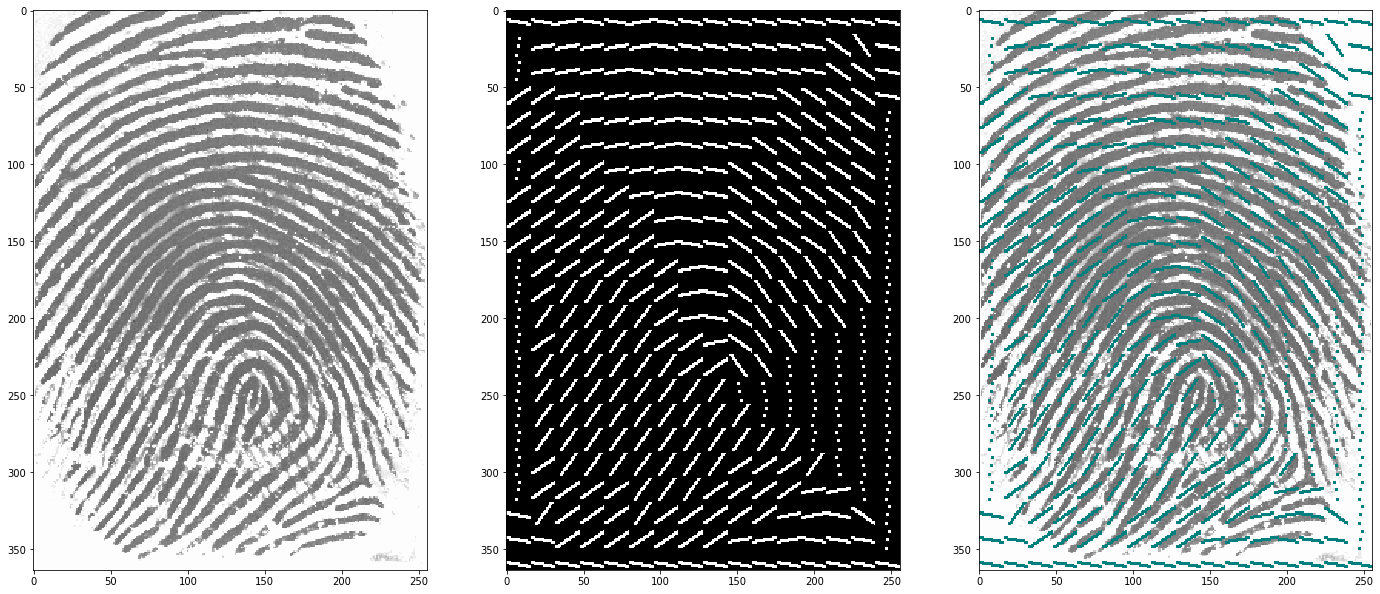

In [12]:
blockSize=(16,16)
quantization=8
color=[0,127,127]
drawConfig(image,winSize=blockSize,quantizationFactor=quantization,color=color)

window and image size doesn't match


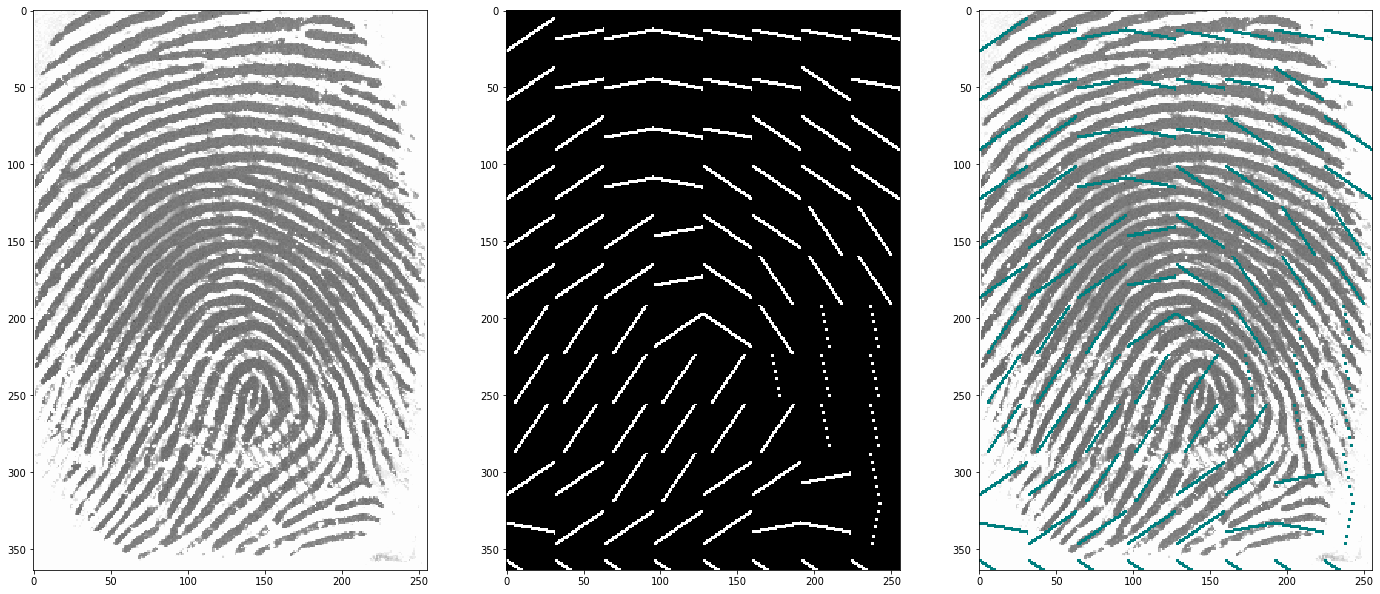

In [13]:
blockSize=(32,32)
quantization=8
color=[0,127,127]
drawConfig(image,winSize=blockSize,quantizationFactor=quantization,color=color)

window and image size doesn't match


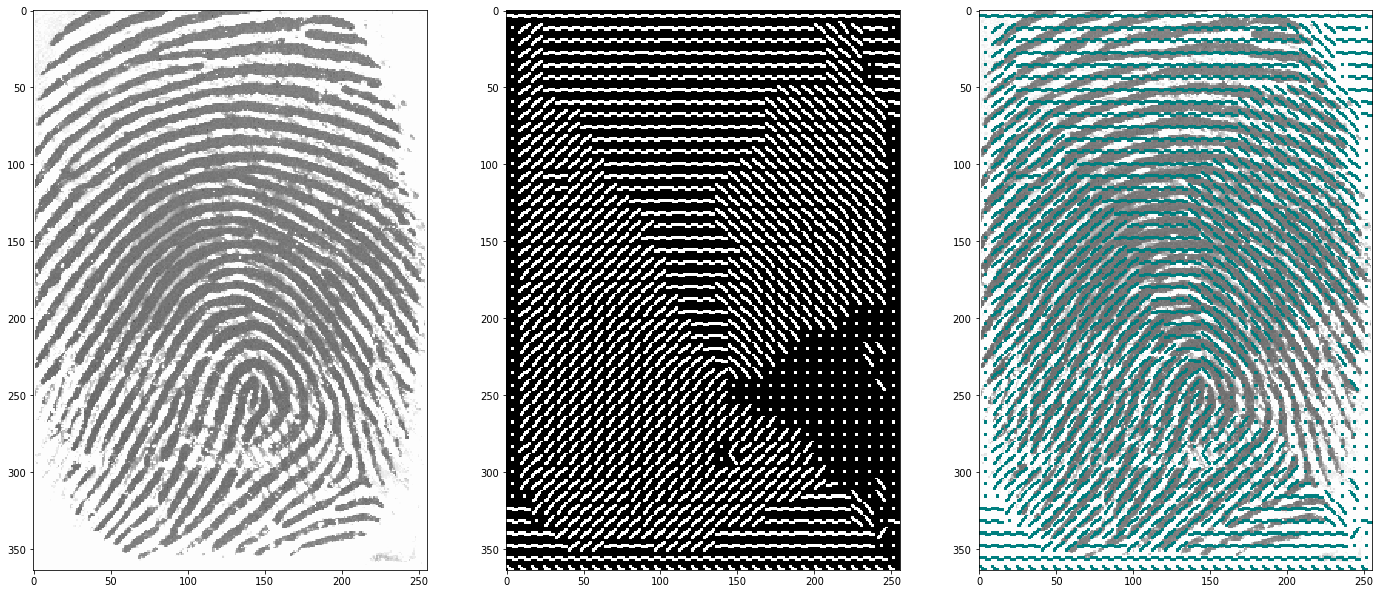

In [14]:
blockSize=(8,8)
quantization=8
color=[0,127,127]
drawConfig(image,winSize=blockSize,quantizationFactor=quantization,color=color)